In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('Avgtemp.csv')

In [2]:
df.Month = pd.to_datetime(df.Month)
df = df.set_index("Month")

In [3]:
train, test = df[:-12], df[-12:]

In [4]:
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [5]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)

In [6]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [7]:
model.fit_generator(generator,epochs=90)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/90
38/38 [==============================] - 1s 20ms/step - loss: 0.1405
Epoch 2/90
38/38 [==============================] - 1s 17ms/step - loss: 0.0541
Epoch 3/90
38/38 [==============================] - 1s 20ms/step - loss: 0.0203
Epoch 4/90
38/38 [==============================] - 1s 20ms/step - loss: 0.0136: 0s - loss:
Epoch 5/90
38/38 [==============================] - 1s 21ms/step - loss: 0.0147
Epoch 6/90
38/38 [==============================] - 1s 17ms/step - loss: 0.0146
Epoch 7/90
38/38 [==============================] - 1s 20ms/step - loss: 0.0083
Epoch 8/90
38/38 [==============================] - 1s 20ms/step - loss: 0.0082
Epoch 9/90
38/38 [==============================] - 1s 20ms/step - loss: 0.0096
Epoch 10/90
38/38 [==============================] - 1s 17ms/step - loss: 0.0064
Epoch 11/90
38/38 [==============================] - 1s 19ms/step - loss: 0.0121
Epoch 12/90
38/38 [===========

In [8]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [9]:
pred_list

[array([0.96339947], dtype=float32),
 array([0.84032345], dtype=float32),
 array([0.60440016], dtype=float32),
 array([0.37061918], dtype=float32),
 array([0.24274665], dtype=float32),
 array([0.18392298], dtype=float32),
 array([0.2145319], dtype=float32),
 array([0.36538243], dtype=float32),
 array([0.54233885], dtype=float32),
 array([0.7459703], dtype=float32),
 array([0.8974226], dtype=float32),
 array([0.9875647], dtype=float32)]

In [10]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=df[-n_input:].index, columns=['Prediction'])

df_test = pd.concat([df,df_predict], axis=1)

In [11]:
actuallast = df_test['Avgtemp'].tail(12)
actuallast

Month
2019-08-01    24.164516
2019-09-01    21.310000
2019-10-01    15.508065
2019-11-01     6.606897
2019-12-01     3.525806
2020-01-01     3.991935
2020-02-01     4.536207
2020-03-01     8.882258
2020-04-01    10.188333
2020-05-01    15.716129
2020-06-01    23.166667
2020-07-01    26.009091
Name: Avgtemp, dtype: float64

In [12]:
predictlast = df_test['Prediction'].tail(12)
predictlast

Month
2019-08-01    26.243480
2019-09-01    22.327352
2019-10-01    14.820561
2019-11-01     7.381935
2019-12-01     3.313188
2020-01-01     1.441490
2020-02-01     2.415429
2020-03-01     7.215309
2020-04-01    12.845846
2020-05-01    19.325150
2020-06-01    24.144177
2020-07-01    27.012388
Name: Prediction, dtype: float64

In [13]:
from sklearn.metrics import mean_squared_error
import math
MSE = mean_squared_error(actuallast,predictlast)
RMSE = math.sqrt(MSE)

In [14]:
forecast_errors = [actuallast[i] - predictlast[i] for i in range(12)]
forecast_errors_abs = [ abs( actuallast[i] - predictlast[i]) for i in range(12)]

BIAS = sum(forecast_errors) * 1.0/len(actuallast)
MAE = sum(forecast_errors_abs) * 1.0/len(actuallast)


from sklearn.metrics import r2_score
r2_score = r2_score(actuallast, predictlast)

In [15]:
print('Train MSE                         : %f' % MSE)
print('Train RMSE                        : %f' % RMSE)
print('Train Bias (Mean Forecast Error)  : %f' % BIAS)
print('Train MAE (Mean Absolute Error)   : %f' % MAE)
print('Train r2_score                    : %f' % r2_score )

Train MSE                         : 3.525531
Train RMSE                        : 1.877640
Train Bias (Mean Forecast Error)  : -0.406700
Train MAE (Mean Absolute Error)   : 1.613083
Train r2_score                    : 0.945998


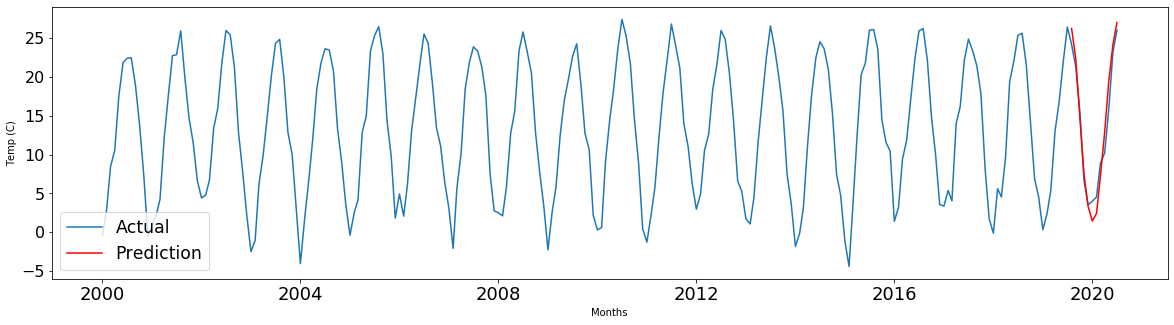

In [16]:
plt.figure(figsize=(20, 5))
plt.plot(df_test.index, df_test['Avgtemp'], label='Actual')
plt.plot(df_test.index, df_test['Prediction'], color='r', label='Prediction')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel("Months")
plt.ylabel("Temp (C)")
plt.show()

In [17]:
pred_actual_rmse = rmse(df_test.iloc[-n_input:, [0]], df_test.iloc[-n_input:, [1]])
print("rmse: ", pred_actual_rmse)

rmse:  [1.87763986]


In [18]:
train = df

train

,Avgtemp
Month,
2000-01-01,-0.404839
2000-02-01,2.934483
2000-03-01,8.441935
2000-04-01,10.551667
2000-05-01,17.512903
...,...
2020-03-01,8.882258
2020-04-01,10.188333
2020-05-01,15.716129


In [19]:
scaler.fit(train)
train = scaler.transform(train)

In [20]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)

In [21]:
model.fit_generator(generator,epochs=90)

Epoch 1/90
40/40 [==============================] - 1s 19ms/step - loss: 0.0048
Epoch 2/90
40/40 [==============================] - 1s 18ms/step - loss: 0.0048
Epoch 3/90
40/40 [==============================] - 1s 17ms/step - loss: 0.0048
Epoch 4/90
40/40 [==============================] - 1s 19ms/step - loss: 0.0049: 0s - los
Epoch 5/90
40/40 [==============================] - 1s 17ms/step - loss: 0.0051
Epoch 6/90
40/40 [==============================] - 1s 18ms/step - loss: 0.0048
Epoch 7/90
40/40 [==============================] - 1s 19ms/step - loss: 0.0060
Epoch 8/90
40/40 [==============================] - 1s 17ms/step - loss: 0.0048
Epoch 9/90
40/40 [==============================] - 1s 17ms/step - loss: 0.0050
Epoch 10/90
40/40 [==============================] - 1s 20ms/step - loss: 0.0044: 0s - los
Epoch 11/90
40/40 [==============================] - 1s 18ms/step - loss: 0.0049
Epoch 12/90
40/40 [==============================] - 1s 19ms/step - loss: 0.0048
Epoch 13/90
40/40

In [22]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [23]:
pred_list

[array([0.9480708], dtype=float32),
 array([0.8418391], dtype=float32),
 array([0.6047687], dtype=float32),
 array([0.35575622], dtype=float32),
 array([0.23373494], dtype=float32),
 array([0.18510038], dtype=float32),
 array([0.20319232], dtype=float32),
 array([0.27079284], dtype=float32),
 array([0.49198925], dtype=float32),
 array([0.6972055], dtype=float32),
 array([0.88231665], dtype=float32),
 array([0.9882507], dtype=float32)]

In [24]:
from pandas.tseries.offsets import DateOffset
add_dates = [df.index[-1] + DateOffset(months=x) for x in range(0,13) ]
future_dates = pd.DataFrame(index=add_dates[1:],columns=df.columns)

In [25]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=future_dates[-n_input:].index, columns=['Prediction'])

df_proj = pd.concat([df,df_predict], axis=1)

In [26]:
predictlast2 = df_predict['Prediction'].tail(12)
predictlast2

2020-08-01    25.755742
2020-09-01    22.375577
2020-10-01    14.832287
2020-11-01     6.909014
2020-12-01     3.026446
2021-01-01     1.478954
2021-02-01     2.054617
2021-03-01     4.205583
2021-04-01    11.243783
2021-05-01    17.773513
2021-06-01    23.663524
2021-07-01    27.034215
Name: Prediction, dtype: float64

In [27]:
actuallast

Month
2019-08-01    24.164516
2019-09-01    21.310000
2019-10-01    15.508065
2019-11-01     6.606897
2019-12-01     3.525806
2020-01-01     3.991935
2020-02-01     4.536207
2020-03-01     8.882258
2020-04-01    10.188333
2020-05-01    15.716129
2020-06-01    23.166667
2020-07-01    26.009091
Name: Avgtemp, dtype: float64

In [28]:
MSE2 = mean_squared_error(actuallast,predictlast2)
RMSE2 = math.sqrt(MSE)

In [29]:
forecast_errors2 = [actuallast[i] - predictlast2[i] for i in range(12)] 
forecast_errors_abs2 = [ abs(actuallast[i] - predictlast2[i]) for i in range(12)]

BIAS2 = sum(forecast_errors2) * 1.0/len(actuallast)
MAE2 = sum(forecast_errors_abs2) * 1.0/len(actuallast)


from sklearn.metrics import r2_score
r2_score2 = r2_score(actuallast, predictlast2)

In [30]:
print('Train MSE                         : %f' % MSE2)
print('Train RMSE                        : %f' % RMSE2)
print('Train Bias (Mean Forecast Error)  : %f' % BIAS2)
print('Train MAE (Mean Absolute Error)   : %f' % MAE2)
print('Train r2_score                    : %f' % r2_score2)

Train MSE                         : 3.787830
Train RMSE                        : 1.877640
Train Bias (Mean Forecast Error)  : 0.271054
Train MAE (Mean Absolute Error)   : 1.536677
Train r2_score                    : 0.941980


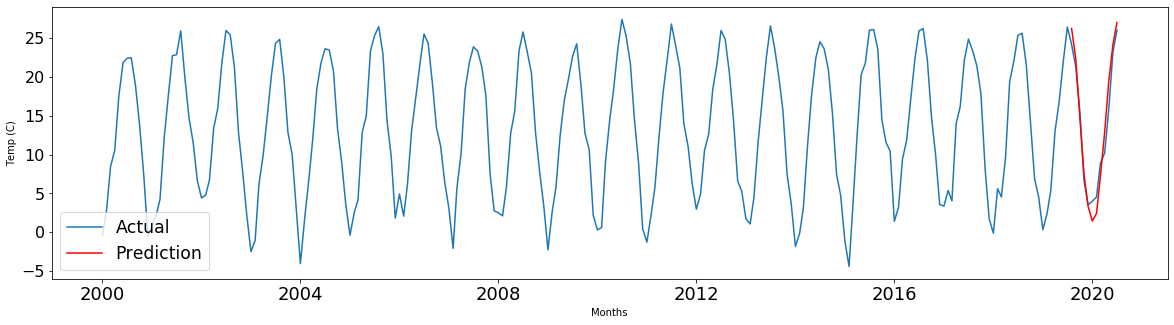

In [31]:
plt.figure(figsize=(20, 5))
plt.plot(df_test.index, df_test['Avgtemp'], label='Actual')
plt.plot(df_test.index, df_test['Prediction'], color='r', label='Prediction')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel("Months")
plt.ylabel("Temp (C)")
plt.show()